In [1]:
import pandas as pd
cust_df = pd.read_csv('customers.csv')
cust_df.shape

(5000, 3)

In [2]:
cust_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [3]:
cust_df.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

<AxesSubplot:>

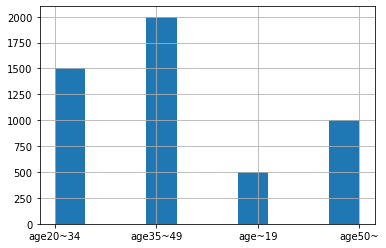

In [4]:
cust_df['age_cat'].hist()

<AxesSubplot:>

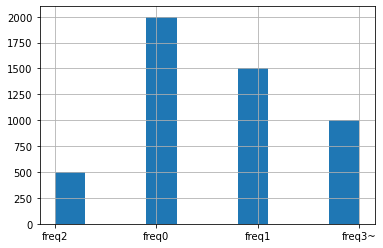

In [5]:
cust_df['freq_cat'].hist()

In [6]:
cust_pivot_df = pd.pivot_table(data=cust_df, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
cust_pivot_df = cust_pivot_df.reindex(['age~19','age20~34','age35~49', 'age50~'])
cust_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


<AxesSubplot:xlabel='freq_cat', ylabel='age_cat'>

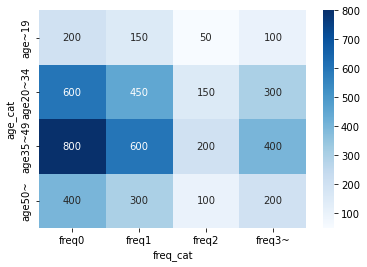

In [7]:
import seaborn as sns
sns.heatmap(cust_pivot_df, annot=True, fmt='d', cmap='Blues')

In [8]:
prob_df = pd.read_csv('visit_probability.csv')
prob_df.shape

(16, 6)

In [9]:
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


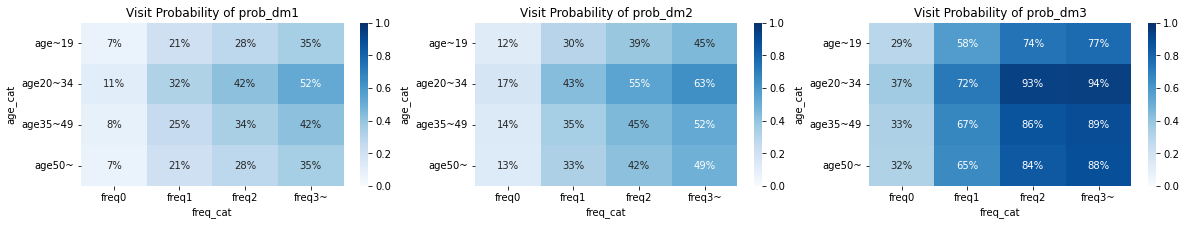

In [10]:
import matplotlib.pyplot as plt
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20,3))
for i, ptn in enumerate(['prob_dm1','prob_dm2','prob_dm3']):
  prob_pivot_df = pd.pivot_table(data=prob_df, values=ptn, columns='freq_cat', index='age_cat')
  prob_pivot_df = prob_pivot_df.reindex(['age~19','age20~34','age35~49','age50~'])
  sns.heatmap(prob_pivot_df,vmin=0,vmax=1,annot=True,fmt='.0%',cmap='Blues',ax=ax[i])
  ax[i].set_title(f'Visit Probability of {ptn}')
plt.show()

In [11]:
import pulp
problem = pulp.LpProblem(name='DiscountCouponProblem1',sense=pulp.LpMaximize)

In [12]:
I = cust_df['customer_id'].to_list()

M = [1,2,3]

xim = {}
for i in I:
  for m in M:
      xim[i,m] = pulp.LpVariable(name=f'xim({i},{m})',cat='Binary')

len(xim)

15000

In [13]:
for i in I:
  problem += pulp.lpSum(xim[i,m] for m in M) == 1

In [14]:
keys = ['age_cat', 'freq_cat']
cust_prob_df = pd.merge(cust_df, prob_df, on=keys)
cust_prob_df.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93


In [15]:
cust_prob_ver_df = cust_prob_df.rename(columns={'prob_dm1':1, 'prob_dm2':2, 'prob_dm3':3}).melt(id_vars=['customer_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
cust_prob_ver_df

,customer_id,dm,prob
0,1,1,0.42
1,199,1,0.42
2,200,1,0.42
3,255,1,0.42
4,269,1,0.42
...,...,...,...
14995,4474,3,0.74
14996,4596,3,0.74
14997,4720,3,0.74
14998,4910,3,0.74


In [16]:
Pim = cust_prob_ver_df.set_index(['customer_id','dm'])['prob'].to_dict()

In [17]:
Pim[1,1]

0.42

In [18]:
problem += pulp.lpSum((Pim[i,m] - Pim[i,1])*xim[i,m] for i in I for m in [2,3])

In [19]:
Cm = {1:0, 2:1000, 3:2000}

In [20]:
problem += pulp.lpSum(Cm[m]*Pim[i,m]*xim[i,m] for i in I for m in [2,3]) <= 1000000

In [21]:
S = prob_df['segment_id'].to_list()
len(S)

16

In [22]:
Ns = cust_prob_df.groupby('segment_id')['customer_id'].count().to_dict()
print(Ns)

{1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [23]:
Si = cust_prob_df.set_index('customer_id')['segment_id'].to_dict()

In [24]:
for s in S:
    for m in M:
        problem += pulp.lpSum(xim[i,m] for i in I if Si[i] == s) >= 0.1 * Ns[s]

In [25]:
import time
time_start = time.time()
status = problem.solve()
time_stop = time.time()
print(f'ステータス:{pulp.LpStatus[status]}')
print(f'目的関数値:{pulp.value(problem.objective):.4}')
print(f'計算時間:{(time_stop - time_start):.3}(秒)')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sasa./miniforge3/envs/py38/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/f1/dg38sdvs7tsgxf3hbspgk1vc0000gn/T/453ae43d04de401989b80a722e4702b6-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/f1/dg38sdvs7tsgxf3hbspgk1vc0000gn/T/453ae43d04de401989b80a722e4702b6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5054 COLUMNS
At line 85055 RHS
At line 90105 BOUNDS
At line 105106 ENDATA
Problem MODEL has 5049 rows, 15000 columns and 40000 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 326.095 - 0.15 seconds
Cgl0004I processed model has 5049 rows, 15000 columns (15000 integer (15000 of which binary)) and 40000 elements
Cutoff increment increased from 1e-05 to 0.00999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.156863


In [31]:
send_dm_df = pd.DataFrame([[xim[i,m].value() for m in M] for i in I], columns=['send_dm1', 'send_dm2', 'send_dm3'])
send_dm_df.head()

,send_dm1,send_dm2,send_dm3
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [32]:
cust_send_df = pd.concat([cust_df[['customer_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
cust_send_df.head()

,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,1.0,0.0
4,5,age35~49,freq0,0.0,1.0,0.0


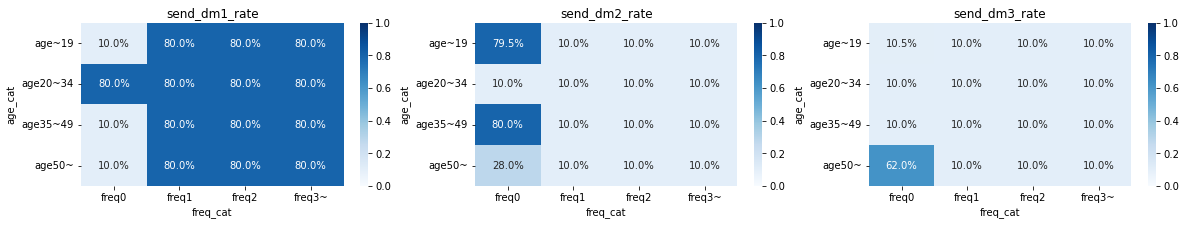

In [33]:
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
  cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
  cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
  sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
  ax[i].set_title(f'{ptn}_rate')
plt.show()

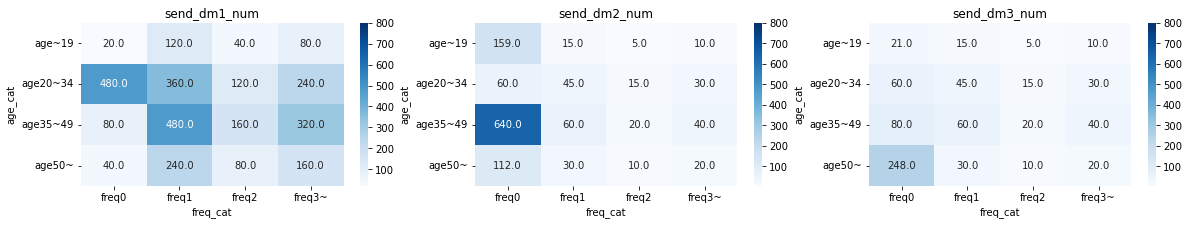

In [34]:
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
  cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='sum')
  cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
  sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmax=800, ax=ax[i])
  ax[i].set_title(f'{ptn}_num')
plt.show()

In [35]:
problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)

In [36]:
xsm = {}
for s in S:
  for m in M:
    xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')
len(xsm)

48

In [37]:
for s in S:
  problem += pulp.lpSum(xsm[s,m] for m in M) == 1

In [38]:
prob_ver_df = prob_df.rename(columns={'prob_dm1':1, 'prob_dm2':2, 'prob_dm3':3}).melt(id_vars=['segment_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
Psm = prob_ver_df.set_index(['segment_id', 'dm'])['prob'].to_dict()

In [39]:
problem += pulp.lpSum(Ns[s]*(Psm[s,m]-Psm[s,1])*xsm[s,m] for s in S for m in [2,3])

In [40]:
problem += pulp.lpSum(Cm[m]*Ns[s]*Psm[s,m]*xsm[s,m] for s in S for m in [2,3]) <= 1000000

In [41]:
for s in S:
  for m in M:
    problem += xsm[s,m] >= 0.1

In [42]:
time_start = time.time()
status = problem.solve()
time_stop = time.time()

print(f'ステータス:{pulp.LpStatus[status]}')
print(f'目的関数:{pulp.value(problem.objective):.4}')
print(f'計算時間:{(time_stop - time_start):.3}(秒)')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sasa./miniforge3/envs/py38/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/f1/dg38sdvs7tsgxf3hbspgk1vc0000gn/T/46e4d2f5e6e142b48e9e44199ed68218-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/f1/dg38sdvs7tsgxf3hbspgk1vc0000gn/T/46e4d2f5e6e142b48e9e44199ed68218-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 17 (-48) rows, 32 (-16) columns and 64 (-64) elements
0  Obj 229 Dual inf 981.57657 (32)
6  Obj 326.0951
Optimal - objective value 326.0951
After Postsolve, objective 326.0951, infeasibilities - dual 11.960784 (3), primal 0 (0)
Presolved model was optimal, full model needs cleaning up

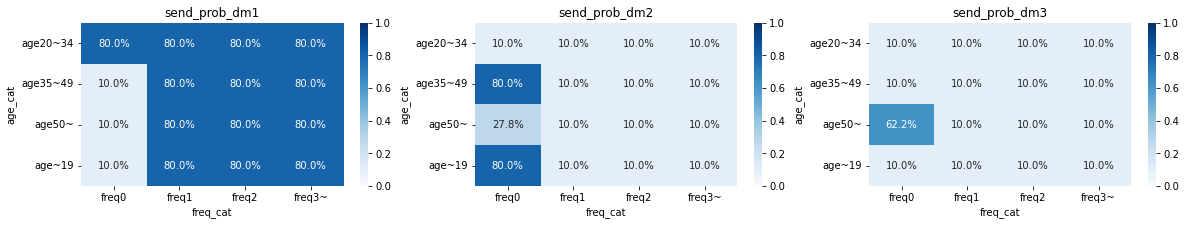

In [43]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M] for s in S], columns=['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)

ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
  seg_send_pivot_df = pd.pivot_table(data=seg_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
  sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
  ax[i].set_title(f'{ptn}')
plt.show()

In [44]:
seg_send_df['num_cust'] = seg_send_df['segment_id'].apply(lambda x: Ns[x])
seg_send_df['send_num_dm1'] = seg_send_df['send_prob_dm1']*seg_send_df['num_cust']
seg_send_df['send_num_dm2'] = seg_send_df['send_prob_dm2']*seg_send_df['num_cust']
seg_send_df['send_num_dm3'] = seg_send_df['send_prob_dm3']*seg_send_df['num_cust']
seg_send_df[['segment_id', 'send_num_dm1', 'send_num_dm2', 'send_num_dm3']].head()

,segment_id,send_num_dm1,send_num_dm2,send_num_dm3
0,1,20.0,160.0,20.0
1,2,120.0,15.0,15.0
2,3,40.0,5.0,5.0
3,4,80.0,10.0,10.0
4,5,480.0,60.0,60.0


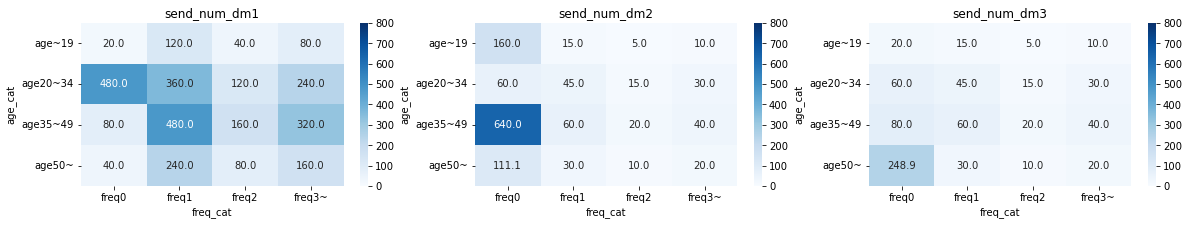

In [45]:
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_num_dm1', 'send_num_dm2', 'send_num_dm3']):
  seg_send_pivot_df = pd.pivot_table(data=seg_send_df, values=ptn, columns='freq_cat', index='age_cat')
  seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
  sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmin=0, vmax=800, ax=ax[i])
  ax[i].set_title(f'{ptn}')
plt.show()

In [46]:
problem = pulp.LpProblem(name='DiscountCouponProblem3', sense=pulp.LpMaximize)

In [47]:
xsm = {}
for s in S:
  for m in M:
    xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')

y = pulp.LpVariable(name='y', lowBound=0, upBound=1, cat='Continuous')

In [48]:
problem += y

In [49]:
for s in S:
  for m in M:
    problem += xsm[s,m] >= y

In [50]:
for s in S:
  problem += pulp.pulp.lpSum(xsm[s,m] for m in M) == 1

problem += pulp.lpSum(Cm[m]*Ns[s]*Psm[s,m]*xsm[s,m] for s in S for m in [2,3]) <= 1000000

In [51]:
status = problem.solve()
max_lowerbound = pulp.value(problem.objective)
print(f'ステータス :{pulp.LpStatus[status]}, 目的関数値:{max_lowerbound:.3}')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sasa./miniforge3/envs/py38/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/f1/dg38sdvs7tsgxf3hbspgk1vc0000gn/T/f6d7129d567243b8b09364a76e2bb828-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/f1/dg38sdvs7tsgxf3hbspgk1vc0000gn/T/f6d7129d567243b8b09364a76e2bb828-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 248 RHS
At line 314 BOUNDS
At line 364 ENDATA
Problem MODEL has 65 rows, 49 columns and 176 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 49 (-16) rows, 33 (-16) columns and 144 (-32) elements
Perturbing problem by 0.001% of 0.62819912 - largest nonzero change 0.00094529304 ( 0.15047666%) - largest zero change 9.6171668e-05
0  Obj -0 Dual inf 0.62725282 (1)
31  Obj 0.13116342 Primal inf 0.17027776 (2)
33  Obj 0.13040049

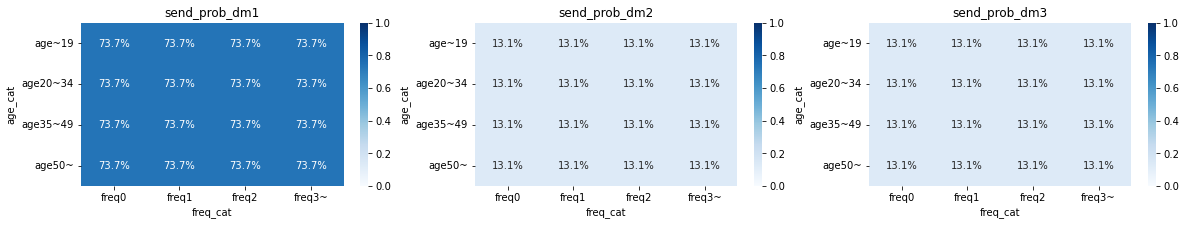

In [56]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M] for s in S], columns=['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)

ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
  seg_send_pivot_df = pd.pivot_table(data=seg_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
  seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
  sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
  ax[i].set_title(f'{ptn}')
plt.show()

In [58]:
problem = pulp.LpProblem(name='DiscountCouponProblem3', sense=pulp.LpMaximize)

x = {}
for s in S:
  for m in M:
    xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')

for s in S:
  problem += pulp.lpSum(xsm[s,m] for m in M) == 1

problem += pulp.lpSum(Ns[s]*(Psm[s,m] - Psm[s,1])*xsm[s,m] for s in S for m in [2,3])

problem += pulp.lpSum(Cm[m]*Ns[s]*Psm[s,m]*xsm[s,m] for s in S for m in [2,3]) <= 1000000

for s in S:
  for m in M:
    problem += xsm[s,m] >= max_lowerbound

status = problem.solve()
print(f'ステータス:{pulp.LpStatus[status]}, 目的関数値:{pulp.value(problem.objective):.4}')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sasa./miniforge3/envs/py38/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/f1/dg38sdvs7tsgxf3hbspgk1vc0000gn/T/2e4e66829463439ea4af1184104cea97-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/f1/dg38sdvs7tsgxf3hbspgk1vc0000gn/T/2e4e66829463439ea4af1184104cea97-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 17 (-48) rows, 32 (-16) columns and 64 (-64) elements
0  Obj 300.58409 Dual inf 981.57657 (32)
1  Obj 300.58411
Optimal - objective value 300.58411
After Postsolve, objective 300.58411, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 300.5841097 - 1 iterations time 0.002,

In [59]:
cost_list = []
cpa_list = []
inc_action_list = []

In [64]:
print('ステータス,キャンペーン費用,来客増加数,CPA')
for cost in range(761850, 3000000, 100000):
  problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)

  xsm = {}
  for s in S:
    for m in M:
      xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')

  for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M) == 1
  
  problem += pulp.lpSum(Ns[s]*(Psm[s,m] - Psm[s,1])*xsm[s,m] for s in S for m in [2,3])

  problem += pulp.lpSum(Cm[m]*Ns[s]*Psm[s,m]*xsm[s,m] for s in S for m in [2,3]) <= cost

  for s in S:
    for m in M:
      problem += xsm[s,m] >= 0.1

  status = problem.solve()
  cpa = cost/pulp.value(problem.objective)
  inc_action = pulp.value(problem.objective)
  cost_list.append(cost)
  cpa_list.append(cpa)
  inc_action_list.append(inc_action)
  print(f'{pulp.LpStatus[status]}, {cost}, {inc_action:.4}, {cpa:.5}')

ステータス,キャンペーン費用,来客増加数,CPA
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sasa./miniforge3/envs/py38/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/f1/dg38sdvs7tsgxf3hbspgk1vc0000gn/T/ef948d4391984bf5933be3ed4d0c216a-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/f1/dg38sdvs7tsgxf3hbspgk1vc0000gn/T/ef948d4391984bf5933be3ed4d0c216a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-65) rows, 0 (-48) columns and 0 (-128) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 229
After Postsolve, objective 229, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 229 - 0 iterations time 0.002, Preso

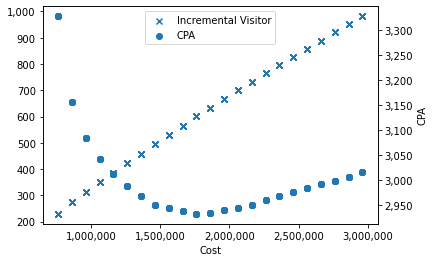

In [65]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(cost_list, inc_action_list, marker='x', label='Incremental Visitor')
ax2.scatter(cost_list, cpa_list, label='CPA')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:f'{x:,.0f}'))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:f'{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:f'{x:,.0f}'))
ax1.set_xlabel('Cost')
ax2.set_ylabel('Incremental visitor')
ax2.set_ylabel('CPA')
reg1, label1 = ax1.get_legend_handles_labels()
reg2, label2 = ax2.get_legend_handles_labels()
ax2.legend(reg1 + reg2, label1 + label2, loc='upper center')
plt.show()